In [2]:
# run at start and restart session for datasets functions to work
!pip install evaluate
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [3]:
!wandb login 3f19a3908ddb5811a9fe7aa0ef1d444b6c9d8a2d

wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [4]:
import wandb

In [5]:
# set device to gpu
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [6]:
# Reproducibility
# https://darinabal.medium.com/deep-learning-reproducible-results-using-pytorch-42034da5ad7

SEED = 2025

import random
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch
import torch.cuda
import torch.backends.cudnn

def set_determenistic_mode(SEED, disable_cudnn=False):
    rs = RandomState(MT19937(SeedSequence(SEED))) # If any of the libraries or code rely on NumPy seed the global NumPy RNG.
    random.seed(SEED)                             # Set python seed for custom operators.
    np.random.seed(SEED)
    torch.manual_seed(SEED)                       # Seed the RNG for all devices (both CPU and CUDA).
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)              # If you are using multi-GPU. In case of one GPU, you can use # .

    g = torch.Generator() #device=device
    g.manual_seed(SEED)

    if not disable_cudnn:
        torch.backends.cudnn.deterministic = True # Causes cuDNN to use a deterministic convolution algorithm,
                                                # but may slow down performance.
                                                # It will not guarantee that your training process is deterministic
                                                # if you are using other libraries that may use nondeterministic algorithms
        torch.backends.cudnn.benchmark = False    # Causes cuDNN to deterministically select an algorithm,
                                                # possibly at the cost of reduced performance
                                                # (the algorithm itself may be nondeterministic).
    else:
        torch.backends.cudnn.enabled = False # Controls whether cuDNN is enabled or not.
                                            # If you want to enable cuDNN, set it to True.

    return g


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)



In [7]:
# Data Preparation

# get data and split it
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch.nn as nn
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

def build_dataset(seed, checkpoint):
    # read in data and split it
    data = pd.read_csv("TAB_binaryLabel.csv")
    train_data, test_data = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=seed)
    train_data.to_csv("train_data.csv", index=False)
    test_data.to_csv("test_data.csv", index=False)

    # get class weights
    # class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data["label"]), y=train_data["label"])
    # class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
    pos_fraction = (train_data["label"] == 1).mean()
    neg_fraction = 1.0 - pos_fraction
    pos_weight = torch.tensor([neg_fraction / pos_fraction]).to(device)

    # load data as huggingface dataset
    data = load_dataset("csv", data_files={"train": "train_data.csv", "test": "test_data.csv"})
    # data = data.train_test_split(test_size=0.2, seed=2025)

    # tokenize data
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    def tokenize_function(example):
        return tokenizer(example["TAB_preproc"], truncation=True, max_length=512)
    tokenized_datasets = data.map(tokenize_function, batched=True)

    # remove columns that the model doesn't take
    tokenized_datasets = tokenized_datasets.remove_columns(["TAB","TAB_preproc"])
    tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
    tokenized_datasets.set_format("torch")
    return tokenized_datasets, data_collator, pos_weight

# init dataloaders
from torch.utils.data import DataLoader
def build_dataloaders(tokenized_datasets, batch_size, data_collator, g):
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator,
        worker_init_fn=seed_worker, generator=g,
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
    )
    return train_dataloader, eval_dataloader
    # {k: v.shape for k, v in batch.items()}

In [8]:
# Model Init

# init model
from transformers import AutoModelForSequenceClassification
def build_model(checkpoint, dropout):
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1,
                                                               hidden_dropout_prob=dropout,
                                                               attention_probs_dropout_prob=dropout)
    return model
    # outputs = model(**batch)
    # print(outputs.loss, outputs.logits.shape)

# init optimizer
from torch.optim import AdamW
def build_opt(model, lr):
    optimizer = AdamW(model.parameters(), lr=lr)
    return optimizer

# init learning rate scheduler
from transformers import get_scheduler
def build_scheduler(train_dataloader_len, optimizer, epochs):
    num_training_steps = epochs * train_dataloader_len
    lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )
    return lr_scheduler
    # print(f"num training steps: {num_training_steps}")

In [10]:
# Training

from tqdm.auto import tqdm
import evaluate
from sklearn.metrics import f1_score

def train(config=None):

    if type(config) == wandb.sdk.wandb_run.Run:
        # single run
        wandbRun = config
    else:
        # normal sweep
        wandbRun = wandb.init(config=config)
    config = wandbRun.config

    g = set_determenistic_mode(config.seed)

    tokenized_datasets, data_collator, pos_weight = build_dataset(config.seed, config.checkpoint)
    if config.weighted:
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    else:
        loss_fn = nn.BCEWithLogitsLoss()
    train_dataloader, eval_dataloader = build_dataloaders(tokenized_datasets, config.batch_size, data_collator, g)
    num_training_steps = len(train_dataloader)*config.epochs
    model = build_model(config.checkpoint, config.dropout)
    optimizer = build_opt(model, config.lr)
    lr_scheduler = build_scheduler(num_training_steps, optimizer, config.epochs)

    # init performance df and tqdm bar
    eval_df = pd.DataFrame(index=range(config.epochs), columns=['avg_train_loss', 'avg_val_loss', 'prec', 'recall', 'f1'])
    train_progress_bar = tqdm(range(num_training_steps))

    best_recall = 70
    model.to(device)
    model.train()
    for epoch in range(config.epochs):
        g.manual_seed(config.seed + epoch) # reset generator for new batch shuffling (different but reproducible shuffling)
        train_losses = []
        # train
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            loss = loss_fn(logits, batch["labels"].float().unsqueeze(1))
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            train_progress_bar.update(1)
            train_losses.append(loss.detach().cpu().item())
        avg_train_loss = sum(train_losses) / len(train_losses)

        # evaluate
        val_progress_bar = tqdm(range(len(eval_dataloader)))

        precision = evaluate.load("precision")
        recall = evaluate.load("recall")
        f1 = evaluate.load("f1")
        accuracy = evaluate.load("accuracy")

        model.eval()
        all_probs = []
        all_labels = []
        for batch in eval_dataloader:
            val_losses = []
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
                logits = outputs.logits
                loss = loss_fn(logits, batch["labels"].float().unsqueeze(1))
                val_losses.append(loss.detach().cpu().item())
            avg_val_loss = sum(val_losses) / len(val_losses)

            probs = torch.sigmoid(logits)
            all_probs.append(probs.detach().cpu())
            all_labels.append(batch["labels"].cpu())
            # preds = (probs >= 0.5).long().squeeze()
            # preds = torch.argmax(logits, dim=-1)
            # # add one batch at a time
            # precision.add_batch(predictions=preds, references=batch["labels"])
            # recall.add_batch(predictions=preds, references=batch["labels"])
            # f1.add_batch(predictions=preds, references=batch["labels"])
            # accuracy.add_batch(predictions=preds, references=batch["labels"])
            val_progress_bar.update(1)

        # save probabilities and labels to df
        all_probs = [
            prob.item()
            for batch in all_probs
            for prob in batch
        ]
        all_labels = [
            label.item()
            for batch in all_labels
            for label in batch
        ]
        prob_label_df = pd.DataFrame({"probs": all_probs, "labels": all_labels})
        prob_label_df.to_csv("prob_label_df.csv", index=False)

        # find best threshold and add all batches at once to metrics
        best_thresh = 0
        best_f1 = 0
        # best_prec = 0
        # best_recall = 0
        for t in np.arange(0.0, 1.01, 0.01):
            preds = (all_probs > t).astype(int)
            temp_f1 = f1_score(all_labels, preds)
            if temp_f1 > best_f1:
                best_f1 = temp_f1
                best_thresh = t
        preds = (all_probs > best_thresh).astype(int)
        # prec = precision_score(all_labels, preds, zero_division=0)
        # recall = recall_score(all_labels, preds)

        precision.add_batch(predictions=preds, references=all_labels) #batch["labels"]
        recall.add_batch(predictions=preds, references=all_labels)
        f1.add_batch(predictions=preds, references=all_labels)
        accuracy.add_batch(predictions=preds, references=all_labels)

        # get eval metrics
        prec = precision.compute(average=None)['precision'][1]
        recall = recall.compute(average=None)['recall'][1]
        f1 = f1.compute(average=None)['f1'][1]
        acc = accuracy.compute()

        # log to wandb
        wandbRun.log({
            "avg_train_loss": avg_train_loss,
            "avg_val_loss": avg_val_loss,
            "prec": prec,
            "recall": recall,
            "f1": f1,
            "acc": acc,
        })

        # # save best model
        # if prec > best_prec:
        #     best_prec = %precision
        #     model.save_pretrained(f"bertmini{str(prec)[2:4]}")

        # eval_df.loc[epoch] = [avg_train_loss, avg_val_loss, f"{prec:.4f}", f"{recall:.4f}", f"{f1:.4f}"]
        # # print metrics
        # print(f"train loss: {avg_train_loss}")
        # print(f"val loss: {avg_val_loss}")
        # print(f"precision: {prec}")
        # print(f"recall: {recall}")
        # print(f"f1: {f1}")
        # print(f"accuracy: {acc}")

    wandbRun.finish()

In [23]:
#checkpoints: "boltuix/bert-mini" distilbert/distilbert-base-uncased-finetuned-sst-2-english, google-bert/bert-base-cased,

In [127]:
wandbRun.finish()

In [128]:
# wandb run
wandbRun = wandb.init(
    entity = "lvairus1-harvey-mudd-college",
    project = "test",
    config = {
        "epochs": 10,
        "lr": 0.00001,
        "batch_size": 32,
        "checkpoint": "boltuix/bert-mini",
        "seed": 2025,
        "dropout": 0.5,
        "weighted": True
    }
)

all_probs = train(wandbRun)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,███▇▆▄▄▃▂▁
avg_val_loss,███▆▅▄▃▃▂▁
f1,▁▃▅▆▆▆▇██▇
prec,▁▆▄▆▆▆▇█▇▇
recall,█▁▇▆▆▆▅▆▇▆
avg_train_loss,0.69875
avg_val_loss,0.3823
f1,0.44032
prec,0.36245
recall,0.56081


In [17]:
df = pd.read_csv("prob_label_df.csv")
df

,probs,labels
0,0.200624,0
1,0.203013,0
2,0.792438,0
3,0.205315,0
4,0.609452,0
...,...,...
1540,0.192278,0
1541,0.268462,0
1542,0.781330,1
1543,0.199256,0


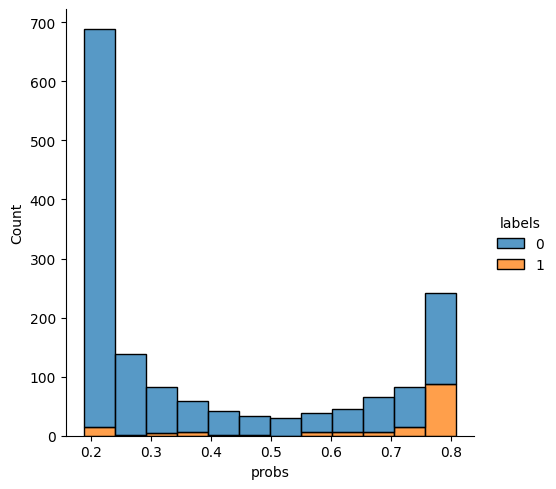

In [22]:
sns.displot(x=df["probs"], hue=df["labels"],multiple="stack")

<Axes: xlabel='probs', ylabel='labels'>

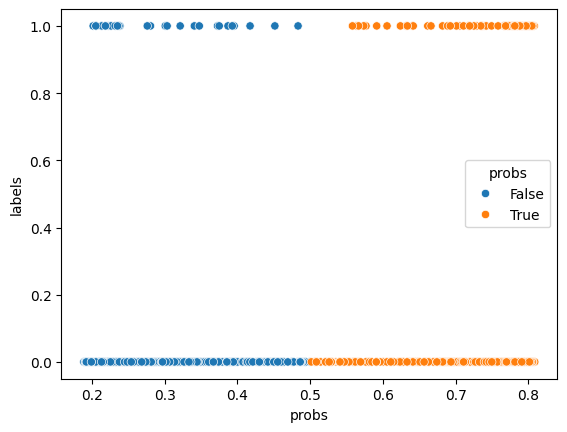

In [18]:
import seaborn as sns
sns.scatterplot(x=df["probs"], y=df["labels"], hue=df["probs"] >= 0.5)

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

best_thresh = 0
best_prec = 1
best_recall = 1
best_f1 = 0

all_p = []
all_r = []
all_f = []

for t in np.arange(0.0, 1.01, 0.01):
    preds = (df["probs"] > t).astype(int)
    prec = precision_score(df["labels"], preds, zero_division=0)
    recall = recall_score(df["labels"], preds)
    f1 = f1_score(df["labels"], preds)
    all_p.append(prec)
    all_r.append(recall)
    all_f.append(f1)
    if f1 > best_f1:
        best_prec = prec
        best_recall = recall
        best_f1 = f1
        best_thresh = t

print(f"Best threshold: {best_thresh:.2f}, prec: {best_prec:.4f}, recall: {best_recall:.4f}, F1-score: {best_f1:.4f}")

Best threshold: 0.77, prec: 0.3981, recall: 0.5541, F1-score: 0.4633


<Axes: >

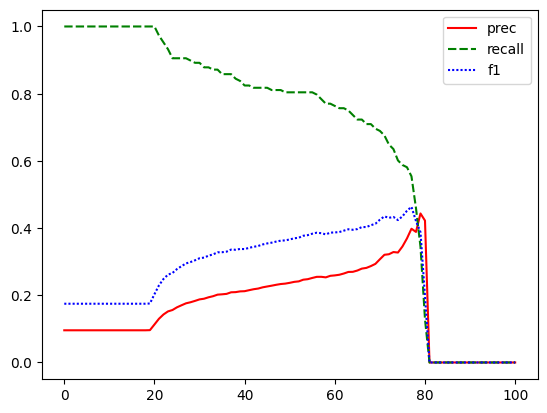

In [20]:
metric_df = pd.DataFrame({"prec": all_p, "recall": all_r, "f1":all_f})
sns.lineplot(data=metric_df[["prec", "recall", "f1"]], palette=['red', 'green', 'blue'])

In [15]:
# wandb sweep
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "prec",
        "goal": "maximize",
    },
    "parameters": {
        "checkpoint": {
            "value": "boltuix/bert-mini"
        },
        "epochs": {
            "value": 10
        },
        "optimizer": {
            "value": "adam"
        },
        "lr": {
            "values": [0.0001, 0.00001]
        },
        "batch_size": {
            "values": [16, 32, 64]
        },
        "dropout": {
            "values": [0.1, 0.25, 0.5]
        },
        "seed": {
            "value": 2025
        },
        "weighted": {
            "value": True
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="CTC")
sweep_id

Create sweep with ID: upslfqce
Sweep URL: https://wandb.ai/lvairus1-harvey-mudd-college/CTC/sweeps/upslfqce


'upslfqce'

In [16]:
wandb.agent(sweep_id, train) #count=18

wandb: Agent Starting Run: 2nqmf3xd with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,█▆▅▃▂▂▁▁▁▁
avg_val_loss,▃▃▁▁▁▁█▁▂▂
f1,▃█▆▅▃▄▃▂▃▁
prec,▂█▆▄▂▃▆▆▃▁
recall,▆█▇▆▇▆▂▁▅▃
avg_train_loss,0.07741
avg_val_loss,0.59514
f1,0.37811
prec,0.29921
recall,0.51351


wandb: Agent Starting Run: 9k7cuzib with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,█▇▆▅▄▃▃▂▂▁
avg_val_loss,█▆▅▃▂▂▁▂▁▂
f1,▁▅▆███▇▅▆▅
prec,▁▅███▅▄▂▆▃
recall,▁▂▁▃▄▇▇█▄▆
avg_train_loss,0.40871
avg_val_loss,0.38092
f1,0.42607
prec,0.33865
recall,0.57432


wandb: Agent Starting Run: kg4b0upp with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,█▇▅▄▃▂▂▁▁▁
avg_val_loss,▆▄▃▄▃▂▂▇▁█
f1,▁█▇▅▅▆▄▆▆▅
prec,▁▇▅▅▅▅▄▄▇█
recall,█▅▇▄▄▇▅▇▃▁
avg_train_loss,0.03598
avg_val_loss,1.32933
f1,0.41549
prec,0.43382
recall,0.39865


wandb: Agent Starting Run: edd0u16i with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,█▇▆▅▄▄▃▂▂▁
avg_val_loss,█▇▅▃▃▂▂▂▁▂
f1,▁▅▆▇█▇▇▇▇▆
prec,▁▁▂██▃█▅▆▄
recall,▁▅▇▅▆█▄▆▅▆
avg_train_loss,0.44352
avg_val_loss,0.39091
f1,0.43434
prec,0.34677
recall,0.58108


wandb: Agent Starting Run: 7ngtzev9 with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,█▇▆▄▃▂▂▁▁▁
avg_val_loss,▅▅▂▄▁▁▁▆▃█
f1,▁▆█▄▆▅▆▅▄▅
prec,▁▅█▆▇▅▅▇▅▄
recall,██▆▁▂▅▇▃▄▇
avg_train_loss,0.09446
avg_val_loss,1.8808
f1,0.4046
prec,0.30662
recall,0.59459


wandb: Agent Starting Run: oe2syknu with config:
wandb: 	batch_size: 16
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3870 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

avg_train_loss,██▇▆▅▄▃▃▂▁
avg_val_loss,██▇▅▄▃▂▃▁▁
f1,▁▄▆▇▇█▇▇▇▇
prec,▁▃▇██▇██▆▇
recall,▇▇▄▁▂▇▄▄█▅
avg_train_loss,0.53461
avg_val_loss,0.24831
f1,0.43158
prec,0.35345
recall,0.55405


wandb: Agent Starting Run: 558sl9q9 with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,█▆▅▃▃▂▂▁▁▁
avg_val_loss,▂▁▁▁▁▂▆▇██
f1,██▇▃▄▅▂▁▂▃
prec,▇█▆▆██▂▃▁▄
recall,█▆█▂▁▂▆▂█▄
avg_train_loss,0.05469
avg_val_loss,5.33654
f1,0.40103
prec,0.32365
recall,0.52703


wandb: Agent Starting Run: ozrwjgwg with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,█▇▆▅▅▄▃▂▂▁
avg_val_loss,█▇▅▄▃▂▂▂▂▁
f1,▁▃▅▆▇▇█▇▇▆
prec,▁▁▃█▆█▇▅▅▄
recall,▂▆▇▁▆▂▆█▆▆
avg_train_loss,0.54423
avg_val_loss,0.33875
f1,0.43108
prec,0.34263
recall,0.58108


wandb: Agent Starting Run: 4nzcoe02 with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,█▇▅▄▃▂▁▁▁▁
avg_val_loss,▂▂▁▂▁▂▇▃▆█
f1,▂▆█▃▄▅▂▄▁▁
prec,▁▅█▁▄▇▄▃▃▆
recall,▆▅▅█▄▃▂▅▃▁
avg_train_loss,0.0712
avg_val_loss,5.48397
f1,0.37975
prec,0.35714
recall,0.40541


wandb: Agent Starting Run: zz7dt9xi with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,██▇▆▅▄▃▂▂▁
avg_val_loss,█▇▆▅▃▂▂▂▁▁
f1,▁▅▆▆▇▇███▇
prec,▁▇▆▅▇▇██▇▅
recall,█▁▃▆▄▄▄▄▄▇
avg_train_loss,0.56582
avg_val_loss,0.37822
f1,0.42826
prec,0.31803
recall,0.65541


wandb: Agent Starting Run: 77cbjckt with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,█▇▆▅▃▂▂▁▁▁
avg_val_loss,▂▂▁▁▂▅▇▇█▆
f1,▁█▇▇▆▆▅▃▂▃
prec,▄▇▅█▄█▆▃▁▂
recall,▁▆▇▄█▃▃▄▆▅
avg_train_loss,0.08942
avg_val_loss,4.02555
f1,0.35821
prec,0.26168
recall,0.56757


wandb: Agent Starting Run: hq3qcndt with config:
wandb: 	batch_size: 32
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1940 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

avg_train_loss,███▇▆▄▄▃▂▁
avg_val_loss,███▆▅▄▃▃▂▁
f1,▁▃▅▆▆▆▇██▇
prec,▁▆▄▆▆▆▇█▇▇
recall,█▁▇▆▆▆▅▆▇▆
avg_train_loss,0.69875
avg_val_loss,0.3823
f1,0.44032
prec,0.36245
recall,0.56081


wandb: Agent Starting Run: 71n4db1m with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,█▆▅▃▃▂▂▁▁▁
avg_val_loss,█▅▅▂▃▂▁▂▁▁
f1,▇█▇▆▂▃▄▁▃▅
prec,▇█▅▇▁▃▆▅▅▅
recall,▅▅█▄█▆▂▁▄▄
avg_train_loss,0.07978
avg_val_loss,0.02931
f1,0.41519
prec,0.33198
recall,0.55405


wandb: Agent Starting Run: pm8ku5xx with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,██▇▆▅▄▃▂▂▁
avg_val_loss,██▆▅▄▃▃▂▁▁
f1,▁▄▅▅▆▆██▇█
prec,▁▃▄▇██▇█▆█
recall,█▆▇▁▁▂▇▆▇▅
avg_train_loss,0.71589
avg_val_loss,0.47521
f1,0.45181
prec,0.40761
recall,0.50676


wandb: Agent Starting Run: gkzyt6oo with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,█▇▅▄▃▂▁▁▁▁
avg_val_loss,▃▂▁▁▁▆▇▄██
f1,▂█▇▄▁▃▂▃▂▂
prec,▃█▇▅▁▆▄▄▄▅
recall,▃▅▄▃█▁▂▅▂▁
avg_train_loss,0.10547
avg_val_loss,3.3582
f1,0.39237
prec,0.32877
recall,0.48649


wandb: Agent Starting Run: 67vh03k7 with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.25
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,██▇▆▅▄▃▃▂▁
avg_val_loss,██▇▆▅▃▃▂▁▁
f1,▁▄▆▆▆▇██▇█
prec,▁▃▆▆▆█▇▇▇█
recall,▇▆▃▅▆▁▇█▅▅
avg_train_loss,0.74219
avg_val_loss,0.50371
f1,0.44382
prec,0.37981
recall,0.53378


wandb: Agent Starting Run: ckwcvx4z with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,█▇▆▅▄▃▂▁▁▁
avg_val_loss,▃▂▁▁▁▁▄▅▄█
f1,▁▇██▇▇▅▆▄▅
prec,▁▄▆▇▅█▅▅▆▆
recall,▅█▆▄▆▂▄▅▁▁
avg_train_loss,0.11605
avg_val_loss,4.62249
f1,0.38312
prec,0.36875
recall,0.39865


wandb: Agent Starting Run: 4q7c1qf4 with config:
wandb: 	batch_size: 64
wandb: 	checkpoint: boltuix/bert-mini
wandb: 	dropout: 0.5
wandb: 	epochs: 10
wandb: 	lr: 1e-05
wandb: 	optimizer: adam
wandb: 	seed: 2025
wandb: 	weighted: True


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/6180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at boltuix/bert-mini and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/970 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

avg_train_loss,███▇▆▅▄▃▂▁
avg_val_loss,███▇▆▅▄▃▁▁
f1,▁▄▅▅▆▆▇▇▇█
prec,▁▃▄▅▆▆▇█▇█
recall,█▅▅▂▂▂▁▁▂▂
avg_train_loss,0.86295
avg_val_loss,0.66708
f1,0.46328
prec,0.39806
recall,0.55405


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
# testing using a personally saved model
saved_model = AutoModelForSequenceClassification.from_pretrained("./bertmini81").to(device)

In [ ]:
import evaluate

precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

progress_bar = tqdm(range(len(eval_dataloader)))

saved_model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = saved_model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    precision.add_batch(predictions=predictions, references=batch["labels"])
    recall.add_batch(predictions=predictions, references=batch["labels"])
    f1.add_batch(predictions=predictions, references=batch["labels"])
    accuracy.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)

print(f"precision: {precision.compute(average=None)}")
print(f"recall: {recall.compute(average=None)}")
print(f"f1: {f1.compute(average=None)}")
print(f"accuracy: {accuracy.compute()}")

  0%|          | 0/194 [00:00<?, ?it/s]

precision: {'precision': array([0.97378277, 0.25157233])}
recall: {'recall': array([0.7444524 , 0.81081081])}
f1: {'f1': array([0.84381339, 0.384     ])}
accuracy: {'accuracy': 0.7508090614886731}


In [ ]:
predictions

tensor([0], device='cuda:0')